# Judges Prizes Notebook

This notebook contains the accompanying code that was used to generate the figures and answers that are presented in the judges prizes solution from "Los Rodriguez" team.

In [1]:
# basic data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from statsmodels.stats.multitest import multipletests

# utils
import warnings
import time

# single cell data analysis libraries
import anndata
import decoupler as dc

# neural net and keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, GaussianNoise

# chemical libraries
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

# suppress warnings
warnings.filterwarnings('ignore')

# all functions for the judges prizes notebook are loaded here
from judges_prizes_helpers import *

# deactivate GPU based training, as we obtained weird results with tensorflow metal in the past and CPU training is fast enough
physical_devices = tf.config.list_physical_devices()
tf.config.set_visible_devices(physical_devices[0])

# record initial time
initial_time = time.time()

### Exploratory data analysis

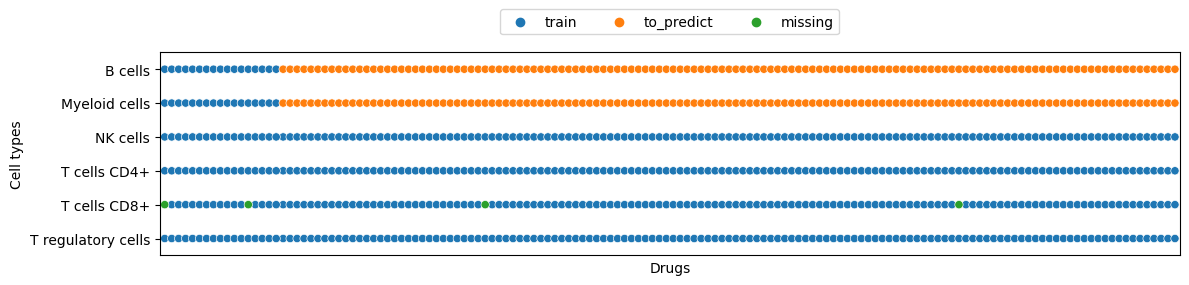

In [2]:
original_de_train = pd.read_parquet('data/source_data/de_train.parquet')
drug_smile = original_de_train[['sm_name', 'SMILES']].drop_duplicates()
plot_availability(original_de_train, fig_height=3)

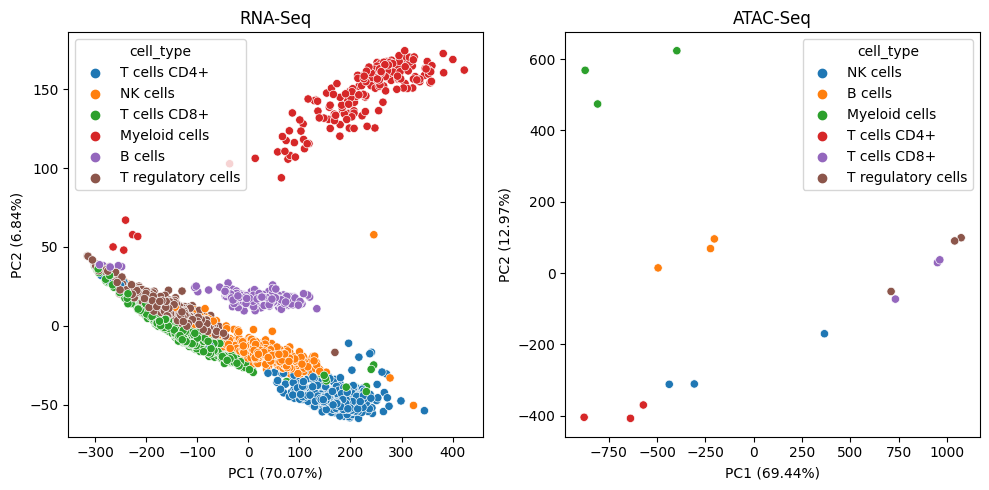

In [3]:
# load pseudobulk profiles
rna_pseudo, rna_pseudo_meta = load_rna_pseudobulk()
atac_pseudo, atac_pseudo_meta = load_atac_pseudobulk()

# we also compute here the fold change from the pseudobulk data, which we will use later
rna_fc = compute_lfc(rna_pseudo, rna_pseudo_meta)

# visualize the pseudobulk profiles in a PCA plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
pcaplot(rna_pseudo, rna_pseudo_meta, axs[0])
atac_pca = pcaplot(atac_pseudo, atac_pseudo_meta, axs[1])
axs[0].set_title('RNA-Seq')
axs[1].set_title('ATAC-Seq')
plt.tight_layout()
plt.show()

### Local CV strategy overview

In [4]:
de_train = pd.read_parquet('data/my_data/local_de_train.parquet')

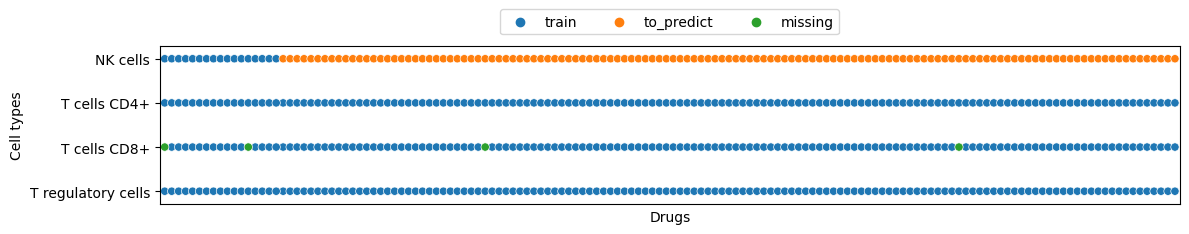

In [5]:
id_map = pd.read_csv('data/source_data/id_map.csv')
challenge_drugs = id_map['sm_name'].unique()
test_de_df = de_train[(de_train['sm_name'].isin(challenge_drugs)) & (de_train['cell_type'] == 'NK cells')]
train_de_df = de_train[~((de_train['sm_name'].isin(challenge_drugs)) & (de_train['cell_type'] == 'NK cells'))]
train_de_df = train_de_df[~ train_de_df['cell_type'].isin(['B cells', 'Myeloid cells'])]
plot_availability(train_de_df, ['NK cells'], fig_height=2.5)

In [6]:
# prepare train and test data for further analyses
train_de_df = train_de_df.set_index(['cell_type', 'sm_name'])
train_fc_df = rna_fc.loc[train_de_df.index, train_de_df.columns]
test_de_df = test_de_df.set_index(['cell_type', 'sm_name'])

# load default parameters for the neural network
params = load_default_params()
params

{'top_n_genes': 128,
 'de_drug_units': 64,
 'de_cell_units': 16,
 'fc_drug_units': 64,
 'fc_cell_units': 16,
 'drug_dense_units': 128,
 'cell_dense_units': 32,
 'n_mid_layers': 2,
 'n_mid_units': 64,
 'noise': 0.05,
 'dropout': 0.3,
 'learning_rate': 0.01,
 'reduce_lr_factor': 0.8,
 'reduce_lr_patience': 10,
 'reduce_lr_min_lr': 1e-06,
 'epochs': 300,
 'batch_size': 128}

### Features and base model overview

In [7]:
# compute features from train data
med_de_drug = train_de_df.groupby('sm_name').median()
med_fc_drug = train_fc_df.groupby('sm_name').median()
med_de_cell = train_de_df.groupby('cell_type').median()
med_fc_cell = train_fc_df.groupby('cell_type').median()

# compute std per gene using train_de_df
genes_std = train_de_df.std(axis=0).sort_values(ascending=False)
top_var_genes = genes_std.index[:params['top_n_genes']]

# prepare features
X_train, X_test, y_train, y_test = prepare_inputs(
    drug_df_list = [med_de_drug, med_fc_drug], 
    cell_df_list = [med_de_cell, med_fc_cell],
    train_df = train_de_df,
    test_df = test_de_df,
    int_features = top_var_genes
)

# define input layers
drug_dict = {
    'fc_drug': {
        'n_inputs' : X_train[0].shape[1], 
        'n_units': params['fc_drug_units'], 
        'dropout': params['dropout'], 
        'noise': params['noise']
    },
    'de_drug': {
        'n_inputs' : X_train[1].shape[1], 
        'n_units': params['de_drug_units'], 
        'dropout': params['dropout'], 
        'noise': params['noise']
    }
}
cell_dict = {
    'fc_cell': {
        'n_inputs' : X_train[2].shape[1],
        'n_units': params['fc_cell_units'],
        'dropout': params['dropout'],
        'noise': params['noise']},
    'de_cell': {
        'n_inputs' : X_train[3].shape[1],
        'n_units': params['de_cell_units'],
        'dropout': params['dropout'],
        'noise': params['noise']
    }
}

# define lr backend
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=params['reduce_lr_factor'], 
    patience=params['reduce_lr_patience'], min_lr=params['reduce_lr_min_lr']
)

In [8]:
basal_model_error = []

for i in range(3):
    
    # define optimizers and compile
    opt = keras.optimizers.legacy.RMSprop(learning_rate=params['learning_rate'])

    # define and compile model
    base_model = neuralnet_regressor(
        drug_dict, cell_dict, y_train.shape[1],
        drug_dense_units = params['drug_dense_units'], 
        cell_dense_units = params['cell_dense_units'],
        n_mid_layers = params['n_mid_layers'], 
        n_mid_units = params['n_mid_units'], 
        dropout=params['dropout']
    )
    base_model.compile(optimizer=opt, loss=mrrmse)

    # train model
    history = base_model.fit(
        X_train, y_train,
        batch_size=params['batch_size'],
        shuffle=True,
        epochs=params['epochs'],
        validation_data=(X_test, y_test),
        callbacks=[reduce_lr],
        verbose=0
    )

    # compute error
    y_test_pred = base_model.predict(X_test, verbose=0)
    y_test_error = mrrmse(test_de_df.values, y_test_pred).numpy()
    print('Error: ' + str(y_test_error))

    # add to list
    basal_model_error.append(y_test_error)

Error: 0.9056456669903893
Error: 0.9026644957441972
Error: 0.92553099676034


### Model with ATAC-Seq features

In [9]:
# prepare atac-seq features: Average log2 expression of top 128 variable genes
genes_in_atac = ([ i for i in train_de_df.columns if i in atac_pseudo.columns ])
atac_features = atac_pseudo[genes_in_atac]
atac_features = np.log2(atac_features.astype(float) + 1)
atac_features['cell_type'] = atac_features.index.str.split('__').str[0]
atac_features = atac_features.groupby('cell_type').mean()
atac_features = atac_features.loc[~atac_features.index.isin(['B cells', 'Myeloid cells'])]
variable_genes = atac_features.std(axis=0).sort_values(ascending=False).index[:128]
atac_features = atac_features[variable_genes]
atac_features

gene,SGCD,PLCB1,PRR5L,LINGO2,PZP,PTGDR,PDGFD,SYTL2,AUTS2,A2M-AS1,...,SLC4A4,ST8SIA6,ATP8B4,IL15,MYBL1,KLRC3,IL2RA,FCRL6,PLXNC1,MYO6
cell_type,,,,,,,,,,,,,,,,,,,,,
NK cells,9.501454,11.605073,9.153685,9.577163,9.569533,8.658966,9.123303,9.381236,10.314103,8.331923,...,6.981179,8.983172,7.736597,7.321126,9.277395,7.952330,4.092816,7.130655,8.057021,7.248615
T cells CD4+,6.573524,11.089510,7.734082,4.575229,8.975437,6.084807,5.538874,9.295440,9.502836,7.859016,...,5.033061,6.890034,5.428467,7.697668,8.844367,5.195300,7.648939,2.964939,8.596267,6.862776
T cells CD8+,0.861654,4.728447,0.528321,0.861654,2.674123,0.528321,0.333333,2.610963,2.918296,0.666667,...,0.333333,1.194988,0.666667,1.486477,2.817070,2.557475,0.666667,0.000000,3.160600,2.302297
T regulatory cells,0.666667,3.122107,1.797439,0.333333,1.302297,0.000000,0.861654,1.797439,2.733224,1.389975,...,0.528321,6.467265,1.584963,2.130772,4.036175,0.333333,7.440450,0.333333,2.194988,0.666667


In [10]:
X_train_atac = X_train + [atac_features.loc[train_de_df.index.get_level_values('cell_type')].values]
X_test_atac = X_test + [atac_features.loc[test_de_df.index.get_level_values('cell_type')].values]

# compute baselines for validation and test data
y_test_zero_error = mrrmse(y_test, np.zeros(y_test.shape)).numpy()

# add input layer for atac-seq
cell_dict_atac = cell_dict.copy()
cell_dict_atac['atac'] = {
    'n_inputs' : X_train_atac[4].shape[1],
    'n_units': params['fc_cell_units'],
    'dropout': params['dropout'],
    'noise': params['noise']
}

In [11]:
atac_model_errors = []

for i in range(3):
    
    # define optimizers and compile
    opt = keras.optimizers.legacy.RMSprop(learning_rate=params['learning_rate'])

    # define and compile model
    atac_model = neuralnet_regressor(
        drug_dict, cell_dict_atac, y_train.shape[1],
        drug_dense_units = params['drug_dense_units'], 
        cell_dense_units = params['cell_dense_units'],
        n_mid_layers = params['n_mid_layers'], 
        n_mid_units = params['n_mid_units'], 
        dropout=params['dropout']
    )
    atac_model.compile(optimizer=opt, loss=mrrmse)

    # train model
    atac_history = atac_model.fit(
        X_train_atac, y_train,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        shuffle=True,
        validation_data=(X_test_atac, y_test),
        callbacks=[reduce_lr],
        verbose=0
    )

    # compute error
    y_test_pred = atac_model.predict(X_test_atac, verbose=0)
    y_test_error = mrrmse(test_de_df.values, y_test_pred).numpy()
    print('Error: ' + str(y_test_error))

    # add to list
    atac_model_errors.append(y_test_error)

Error: 0.8977637186556776
Error: 0.8991100292772803
Error: 0.9377146573512322


### Model with Morgan fingerprints

In [12]:
# create a matrix of morgan fingerprint using the SMILES in the SMILES column of the drug_smile dataframe
n_bits = 512
radius = 2
morgan_fps = np.array([rdMolDescriptors.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(i), radius, nBits = n_bits) for i in drug_smile['SMILES']])
morgan_df = pd.DataFrame(morgan_fps)
morgan_df.set_index(drug_smile['sm_name'], inplace=True)
morgan_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
sm_name,,,,,,,,,,,,,,,,,,,,,
Clotrimazole,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Mometasone Furoate,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
Idelalisib,0,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
Vandetanib,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
Bosutinib,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGM-097,1,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
TGX 221,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Azacitidine,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [13]:
# prepare inputs
morgan_x_train = [morgan_df.loc[train_de_df.index.get_level_values('sm_name')].values]
X_train_morgan = X_train[:2] + morgan_x_train + X_train[2:]
morgan_x_test = [morgan_df.loc[test_de_df.index.get_level_values('sm_name')].values]
X_test_morgan = X_test[:2] + morgan_x_test + X_test[2:]

# add input layer for morgan fingerprints
drug_dict_morgan = drug_dict.copy() 
drug_dict_morgan['morgan'] = {
    'n_inputs' : X_train_morgan[2].shape[1],
    'n_units': params['fc_drug_units'],
    'dropout': params['dropout'],
    'noise': params['noise']
}

In [14]:
morgan_model_errors = []

for i in range(3):

    # define optimizers and compile
    opt = keras.optimizers.legacy.RMSprop(learning_rate=params['learning_rate'])

    # define and compile model
    morgan_model = neuralnet_regressor(
        drug_dict_morgan, cell_dict, y_train.shape[1],
        drug_dense_units = params['drug_dense_units'], 
        cell_dense_units = params['cell_dense_units'],
        n_mid_layers = params['n_mid_layers'], 
        n_mid_units = params['n_mid_units'], 
        dropout=params['dropout']
    )
    morgan_model.compile(optimizer=opt, loss=mrrmse)

    # train model
    morgan_history = morgan_model.fit(
        X_train_morgan, y_train,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        shuffle=True,
        validation_data=(X_test_morgan, y_test),
        callbacks=[reduce_lr],
        verbose=0
    )

    # compute error
    y_test_pred = morgan_model.predict(X_test_morgan, verbose=0)
    y_test_error = mrrmse(test_de_df.values, y_test_pred).numpy()
    print('Error: ' + str(y_test_error))

    # add to list
    morgan_model_errors.append(y_test_error)

Error: 0.9132548542465563
Error: 0.9216158772573879
Error: 0.9191551813227813


### Model with GRN features

In [15]:
# first, we run decoupelR analysis to get the TF activity estimates using the CollecTRI GRN
collectri_df = dc.get_collectri()
# run for response data
response_results = dc.run_ulm(mat = train_de_df.reset_index().drop(['cell_type', 'sm_name'], axis = 1), net = collectri_df, verbose = True)
de_tf_df = response_results[0]
de_tf_df.index = train_de_df.index
# run for fold change data
fc_response_results = dc.run_ulm(mat = train_fc_df.reset_index().drop(['cell_type', 'sm_name'], axis = 1), net = collectri_df, verbose = True)
fc_tf_df = fc_response_results[0]
fc_tf_df.index = train_fc_df.index

Running ulm on mat with 451 samples and 18211 targets for 632 sources.
3 features of mat are empty, they will be removed.
Running ulm on mat with 451 samples and 18208 targets for 632 sources.


In [16]:
# prepare model but using the tf activity estimates to build the features
tf_de_drug = de_tf_df.groupby('sm_name').median()
tf_fc_drug = fc_tf_df.groupby('sm_name').median()
tf_de_cell = de_tf_df.groupby('cell_type').median()
tf_fc_cell = fc_tf_df.groupby('cell_type').median()

# compute std per TF using train_de_df
genes_std = de_tf_df.std(axis=0).sort_values(ascending=False)
top_var_genes = genes_std.index[:params['top_n_genes']]

# prepare features
X_tf_train, X_tf_test, y_train, y_test = prepare_inputs(
    drug_df_list = [tf_de_drug, tf_fc_drug], 
    cell_df_list = [tf_de_cell, tf_fc_cell],
    train_df = train_de_df,
    test_df = test_de_df,
    int_features = top_var_genes
)

In [17]:
tf_model_errors = []
for i in range(3):
    
    # define optimizers and compile
    opt = keras.optimizers.legacy.RMSprop(learning_rate=params['learning_rate'])

    # create model and compile
    tf_model = neuralnet_regressor(
        drug_dict, cell_dict, y_train.shape[1],
        drug_dense_units = params['drug_dense_units'], 
        cell_dense_units = params['cell_dense_units'],
        n_mid_layers = params['n_mid_layers'], 
        n_mid_units = params['n_mid_units'], 
        dropout=params['dropout']
    )
    tf_model.compile(optimizer=opt, loss=mrrmse)

    # train model
    tf_history = tf_model.fit(
        X_tf_train, y_train,
        batch_size=params['batch_size'],
        epochs=params['epochs'],
        validation_data=(X_tf_test, y_test),
        callbacks=[reduce_lr],
        verbose=0
    )

    # compute error
    y_test_pred = tf_model.predict(X_test, verbose=0)
    y_test_error = mrrmse(test_de_df.values, y_test_pred).numpy()
    print('Error: ' + str(y_test_error))

    # add to list
    tf_model_errors.append(y_test_error)

Error: 1.056523848414741
Error: 1.0596465316750094
Error: 1.0639869714723122


### Plot different errors

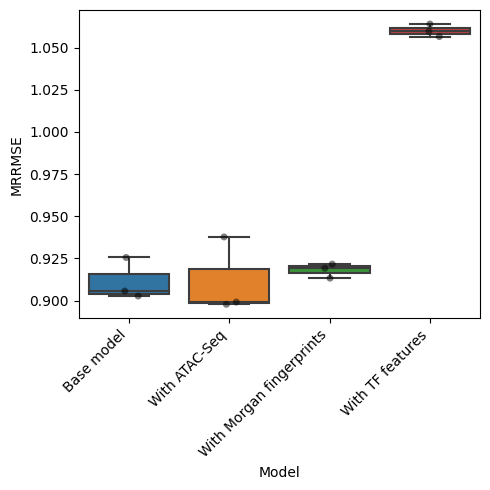

In [18]:
toplot = pd.DataFrame({
    'Base model': basal_model_error,
    'With ATAC-Seq': atac_model_errors,
    'With Morgan fingerprints': morgan_model_errors,
    'With TF features': tf_model_errors
}).melt()

fig, ax = plt.subplots(figsize=(5, 5))

sns.boxplot(data=toplot, x='variable', y='value', ax=ax)
sns.stripplot(data=toplot, x='variable', y='value', ax=ax, color='black', alpha=0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ax.set_ylabel('MRRMSE')
ax.set_xlabel('Model')
plt.tight_layout()

### Drug errors

In [19]:
y_pred_df = base_model.predict(X_test, verbose=0)
y_test_df = test_de_df.copy()

# compute squared errors
error_df = np.sqrt(np.square(y_test_df - y_pred_df))
error_df.index = error_df.index.droplevel('cell_type')

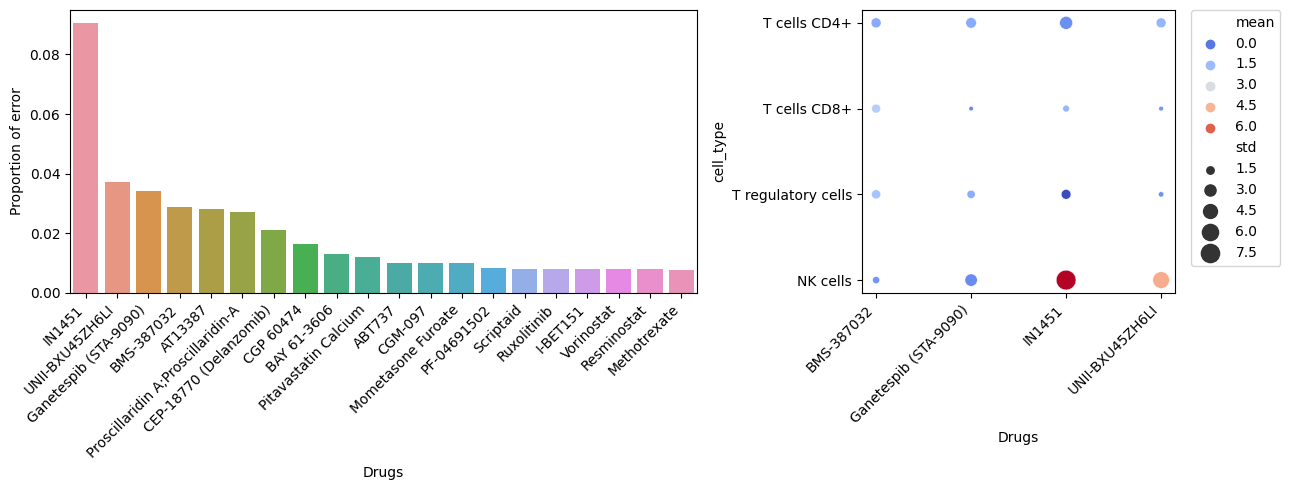

In [20]:
# compute mean error per drug and plot top drugs with higuest error and summary values for top 4 drugs
drug_mean_error = error_df.mean(axis=1).sort_values(ascending=False)
error_proportions = drug_mean_error / drug_mean_error.sum()
int_drugs = error_proportions.index[:4]

# create figures with two axes
fig, axs = plt.subplots(1, 2, figsize=(13, 5), gridspec_kw={'width_ratios': [1, 0.5]})

# barplot with the error of first 20 drugs
sns.barplot(data=error_proportions[:20].reset_index(), x='sm_name', y=0, ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
axs[0].set_xlabel('Drugs')
axs[0].set_ylabel('Proportion of error')

# plot the summary values for top 4 drugs
toplot = pd.concat([train_de_df, test_de_df], axis = 0)
toplot = toplot[toplot.index.get_level_values('sm_name').isin(int_drugs)]
mean_df = toplot.mean(axis=1)
std_df = toplot.std(axis=1)
toplot_df = pd.DataFrame({
    'mean': mean_df, 'std': std_df, 
    'cell_type': toplot.index.get_level_values('cell_type'), 
    'sm_name': toplot.index.get_level_values('sm_name')
})
sns.scatterplot(data=toplot_df, x='sm_name', y='cell_type', hue='mean', size='std', sizes=(10, 200), 
                legend=True, palette=sns.color_palette("coolwarm", as_cmap=True), ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[1].set_xlabel('Drugs')

plt.tight_layout()

### Cell errors

In [21]:
# keep drugs that are shared across all cells
common_drugs = original_de_train['sm_name'].value_counts()[original_de_train['sm_name'].value_counts() == 6].index
orig_de_train = original_de_train.drop(['SMILES', 'sm_lincs_id', 'control'], axis = 1).set_index(['cell_type', 'sm_name'])

# subset dataset to common drugs
orig_de_train = orig_de_train[orig_de_train.index.get_level_values('sm_name').isin(common_drugs)]
all_cell_types = orig_de_train.index.get_level_values('cell_type').unique()
cell_type_de_fc = rna_fc[rna_fc.index.get_level_values('sm_name').isin(common_drugs)]

np.random.seed(1)
random_drugs = np.random.choice(common_drugs, 4, replace=False)
print(random_drugs)

['LDN 193189' 'Dabrafenib' 'Penfluridol' 'Dactolisib']


In [22]:
cell_type_errors = {}
for int_cell in all_cell_types:

    # prepare the cell type specific data
    ct_train_df = orig_de_train[~(
        (orig_de_train.index.get_level_values('cell_type') == int_cell) &
        (orig_de_train.index.get_level_values('sm_name').isin(random_drugs))
    )]
    ct_test_df = orig_de_train[(
        (orig_de_train.index.get_level_values('cell_type') == int_cell) &
        (orig_de_train.index.get_level_values('sm_name').isin(random_drugs))
    )]
    ct_fc_df = cell_type_de_fc[~(
        (cell_type_de_fc.index.get_level_values('cell_type') == int_cell) &
        (cell_type_de_fc.index.get_level_values('sm_name').isin(random_drugs))
    )]

    # compute features from train data
    ct_de_drug = ct_train_df.groupby('sm_name').median()
    ct_fc_drug = ct_fc_df.groupby('sm_name').median()
    ct_de_cell = ct_train_df.groupby('cell_type').median()
    ct_fc_cell = ct_fc_df.groupby('cell_type').median()

    # compute std per gene using train_de_df
    genes_std = ct_train_df.std(axis=0).sort_values(ascending=False)
    top_var_genes = genes_std.index[:params['top_n_genes']]

    # prepare features
    X_train, X_test, y_train, y_test = prepare_inputs(
        drug_df_list = [ct_de_drug, ct_fc_drug], 
        cell_df_list = [ct_de_cell, ct_fc_cell],
        train_df = ct_train_df,
        test_df = ct_test_df,
        int_features = top_var_genes
    )

    # define input layers
    drug_dict = {
        'fc_drug': {
            'n_inputs' : X_train[0].shape[1], 
            'n_units': params['fc_drug_units'], 
            'dropout': params['dropout'], 
            'noise': params['noise']
        },
        'de_drug': {
            'n_inputs' : X_train[1].shape[1], 
            'n_units': params['de_drug_units'], 
            'dropout': params['dropout'], 
            'noise': params['noise']
        }
    }
    cell_dict = {
        'fc_cell': {
            'n_inputs' : X_train[2].shape[1],
            'n_units': params['fc_cell_units'],
            'dropout': params['dropout'],
            'noise': params['noise']},
        'de_cell': {
            'n_inputs' : X_train[3].shape[1],
            'n_units': params['de_cell_units'],
            'dropout': params['dropout'],
            'noise': params['noise']
        }
    }

    # define opt
    opt = keras.optimizers.legacy.RMSprop(learning_rate=params['learning_rate'])

    # define and compile model
    base_model = neuralnet_regressor(
        drug_dict, cell_dict, y_train.shape[1],
        drug_dense_units = params['drug_dense_units'], 
        cell_dense_units = params['cell_dense_units'],
        n_mid_layers = params['n_mid_layers'], 
        n_mid_units = params['n_mid_units'], 
        dropout=params['dropout']
    )
    base_model.compile(optimizer=opt, loss=mrrmse)

    # train model
    history = base_model.fit(
        X_train, y_train,
        batch_size=params['batch_size'],
        shuffle=True,
        epochs=params['epochs'],
        validation_data=(X_test, y_test),
        callbacks=[reduce_lr],
        verbose=0
    )

    # compute error
    y_test_pred = base_model.predict(X_test, verbose=0)
    y_test_error = mrrmse(ct_test_df.values, y_test_pred).numpy()
    print('Error: ' + str(y_test_error))
    
    # add to dict
    cell_type_errors[int_cell] = y_test_error

Error: 0.9462687852401117
Error: 2.1930070344986836
Error: 0.8654533281460619


Error: 0.885530365143903


Error: 0.5514127744032978
Error: 0.9283793871767091


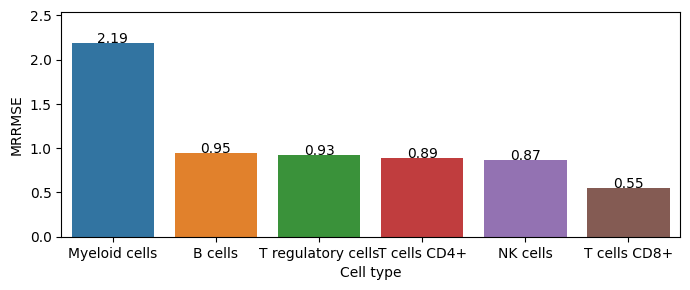

In [23]:
# create toplot dataframe
toplot = pd.DataFrame({
    'cell_type': list(cell_type_errors.keys()),
    'error': list(cell_type_errors.values())
})
toplot = toplot.sort_values('error', ascending=False)

# create plot
plt.figure(figsize=(7, 3))
sns.barplot(data=toplot, x='cell_type', y='error', order=toplot['cell_type'])
plt.ylabel('MRRMSE')
plt.xlabel('Cell type')
for i, v in enumerate(toplot['error']):
    plt.text(i, v, "{:.2f}".format(v), ha="center")
plt.ylim(0, plt.ylim()[1] * 1.1)
plt.tight_layout()

### Gene errors

Running ora on mat with 1 samples and 18211 targets for 50 sources.


100%|██████████| 1/1 [00:00<00:00, 251.58it/s]


Text(0, 0.5, 'Hallmark gene set')

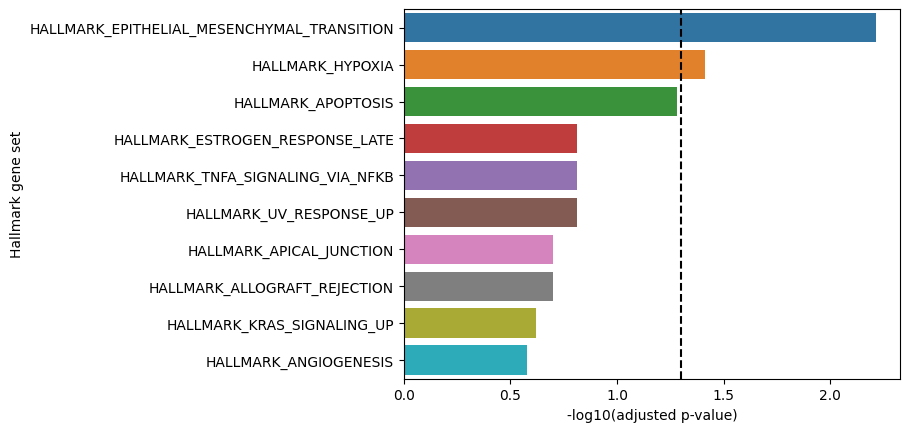

In [24]:
# compute mean error per drug
gene_mean_error = error_df.mean(axis=0).sort_values(ascending=False)
error_proportions = gene_mean_error / gene_mean_error.sum()
gene_error_df = pd.DataFrame({'gene': error_proportions.index, 'error': error_proportions.values})

# prepare decoupler input
to_dc = gene_error_df.set_index('gene').T

# decoupler analysis
msigdb = dc.get_resource('MSigDB')
msigdb = msigdb[msigdb['collection']=='hallmark']
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
results = dc.run_ora(mat = to_dc, net = msigdb, verbose = True, source = 'geneset', target='genesymbol')

# sort, adjust, and plot
ora_pvals = results[1].T.sort_values(by='error', ascending=True)
ora_pvals['adjp'] = multipletests(ora_pvals['error'], method='fdr_bh')[1]
ora_pvals['adjp'] = ora_pvals['adjp'].astype(float)
ora_pvals['log10pval'] = -np.log10(ora_pvals['adjp'])
sns.barplot(data=ora_pvals[:10].reset_index(), y='source', x='log10pval')
plt.axvline(-np.log10(0.05), color='black', linestyle='--')
plt.xlabel('-log10(adjusted p-value)')
plt.ylabel('Hallmark gene set')

### Simpler models

In [25]:
simpler_models_errors = {}
for i in [4, 8, 16, 32, 64, 128]:

    # use only the top i genes
    top_var_genes = genes_std.index[:i]

    # prepare features
    X_train, X_test, y_train, y_test = prepare_inputs(
        drug_df_list = [med_de_drug, med_fc_drug], 
        cell_df_list = [med_de_cell, med_fc_cell],
        train_df = train_de_df,
        test_df = test_de_df,
        int_features = top_var_genes
    )

    # define input layers
    drug_dict = {
        'fc_drug': {
            'n_inputs' : X_train[0].shape[1], 
            'n_units': params['fc_drug_units'], 
            'dropout': params['dropout'], 
            'noise': params['noise']
        },
        'de_drug': {
            'n_inputs' : X_train[1].shape[1], 
            'n_units': params['de_drug_units'], 
            'dropout': params['dropout'], 
            'noise': params['noise']
        }
    }
    cell_dict = {
        'fc_cell': {
            'n_inputs' : X_train[2].shape[1],
            'n_units': params['fc_cell_units'],
            'dropout': params['dropout'],
            'noise': params['noise']},
        'de_cell': {
            'n_inputs' : X_train[3].shape[1],
            'n_units': params['de_cell_units'],
            'dropout': params['dropout'],
            'noise': params['noise']
        }
    }

    # define opt
    opt = keras.optimizers.legacy.RMSprop(learning_rate=params['learning_rate'])

    # define and compile model
    base_model = neuralnet_regressor(
        drug_dict, cell_dict, y_train.shape[1],
        drug_dense_units = params['drug_dense_units'], 
        cell_dense_units = params['cell_dense_units'],
        n_mid_layers = params['n_mid_layers'], 
        n_mid_units = params['n_mid_units'], 
        dropout=params['dropout']
    )
    base_model.compile(optimizer=opt, loss=mrrmse)

    # train model
    history = base_model.fit(
        X_train, y_train,
        batch_size=params['batch_size'],
        shuffle=True,
        epochs=params['epochs'],
        validation_data=(X_test, y_test),
        callbacks=[reduce_lr],
        verbose=0
    )

    # compute error
    y_test_pred = base_model.predict(X_test, verbose=0)
    y_test_error = mrrmse(test_de_df.values, y_test_pred).numpy()
    print('Error: ' + str(y_test_error))

    # add to dict
    simpler_models_errors[i] = y_test_error

Error: 1.0181899133186203
Error: 0.9749403800474574
Error: 0.9442800542956787
Error: 0.9154603805299576
Error: 0.9262034324996985
Error: 0.9146089993309453


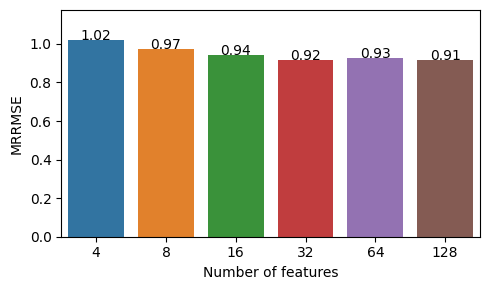

In [26]:
# create toplot dataframe with three columns: n_features, iteration and error
toplot = pd.DataFrame({
    'n_features': list(simpler_models_errors.keys()),
    'error': list(simpler_models_errors.values())
})

# create barplot
plt.figure(figsize=(5, 3))
sns.barplot(data=toplot, x='n_features', y='error')
plt.ylabel('MRRMSE')
plt.xlabel('Number of features')
plt.ylim(0, plt.ylim()[1] * 1.1)
for i, v in enumerate(toplot['error']):
    plt.text(i, v, "{:.2f}".format(v), ha="center")
plt.tight_layout()

### Shuffling for interpretability

In [27]:
shuffling_errors = {
    'original_error': [],
    'shuffled_cell_error': [],
    'shuffled_drug_error': []
}

for i in range(100):
    # compute errores for validation and test data
    y_test_pred = base_model.predict(X_test, verbose=0)
    basal_error = mrrmse(y_test, y_test_pred).numpy()
    shuffling_errors['original_error'].append(basal_error)

    shuffle_cell_input = X_test.copy()
    # shuffle hte columns of the cell input
    shuffle_cell_input[2] = shuffle_cell_input[2][:, np.random.permutation(shuffle_cell_input[2].shape[1])]
    shuffle_cell_input[3] = shuffle_cell_input[3][:, np.random.permutation(shuffle_cell_input[3].shape[1])]
    y_test_pred = base_model.predict(shuffle_cell_input, verbose=0)
    shuffling_errors['shuffled_cell_error'].append(mrrmse(y_test, y_test_pred).numpy())

    shuffle_drug_input = X_test.copy()
    # shuffle hte columns of the drug input
    shuffle_drug_input[0] = shuffle_drug_input[0][:, np.random.permutation(shuffle_drug_input[0].shape[1])]
    shuffle_drug_input[1] = shuffle_drug_input[1][:, np.random.permutation(shuffle_drug_input[1].shape[1])]
    y_test_pred = base_model.predict(shuffle_drug_input, verbose=0)
    shuffling_errors['shuffled_drug_error'].append(mrrmse(y_test, y_test_pred).numpy())

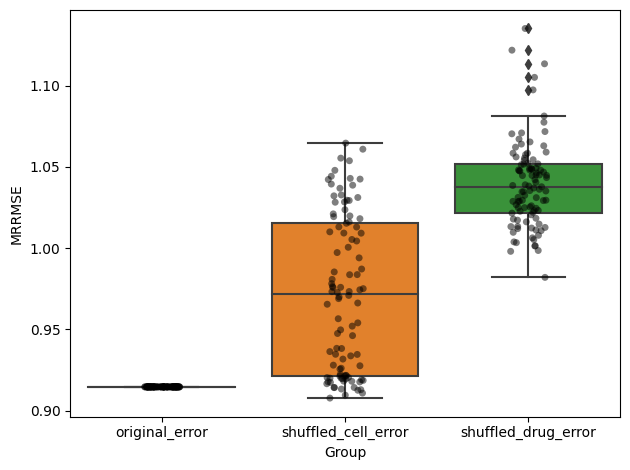

In [28]:
# plot results
toplot = pd.DataFrame(shuffling_errors).melt()
sns.boxplot(data=toplot, x='variable', y='value')
sns.stripplot(data=toplot, x='variable', y='value', color='black', alpha=0.5)
plt.xlabel('Group')
plt.ylabel('MRRMSE')
plt.tight_layout()

### Error with different levels of noise

In [29]:
noise_errors = {}
for i in [0.001, 0.01, 0.05, 0.1, 0.5, 1, 2]:
    # define input layers
    drug_dict = {
        'fc_drug': {
            'n_inputs' : X_train[0].shape[1], 
            'n_units': params['fc_drug_units'], 
            'dropout': params['dropout'], 
            'noise': i
        },
        'de_drug': {
            'n_inputs' : X_train[1].shape[1], 
            'n_units': params['de_drug_units'], 
            'dropout': params['dropout'], 
            'noise': i
        }
    }
    cell_dict = {
        'fc_cell': {
            'n_inputs' : X_train[2].shape[1],
            'n_units': params['fc_cell_units'],
            'dropout': params['dropout'],
            'noise': i
        },
        'de_cell': {
            'n_inputs' : X_train[3].shape[1],
            'n_units': params['de_cell_units'],
            'dropout': params['dropout'],
            'noise': i
        }
    }

    # define opt
    opt = keras.optimizers.legacy.RMSprop(learning_rate=params['learning_rate'])

    # define and compile model
    base_model = neuralnet_regressor(
        drug_dict, cell_dict, y_train.shape[1],
        drug_dense_units = params['drug_dense_units'], 
        cell_dense_units = params['cell_dense_units'],
        n_mid_layers = params['n_mid_layers'], 
        n_mid_units = params['n_mid_units'], 
        dropout=params['dropout']
    )
    base_model.compile(optimizer=opt, loss=mrrmse)

    # train model
    history = base_model.fit(
        X_train, y_train,
        batch_size=params['batch_size'],
        shuffle=True,
        epochs=params['epochs'],
        validation_data=(X_test, y_test),
        callbacks=[reduce_lr],
        verbose=0
    )

    # compute error
    y_test_pred = base_model.predict(X_test, verbose=0)
    y_test_error = mrrmse(test_de_df.values, y_test_pred).numpy()
    print('Error: ' + str(y_test_error))

    # add to dict
    noise_errors[i] = y_test_error

Error: 0.9171761257358257
Error: 0.9095188120225016
Error: 0.9219359251377919
Error: 0.8974857586877807
Error: 0.93472000744497
Error: 1.0613947149461564
Error: 0.9960922911764414


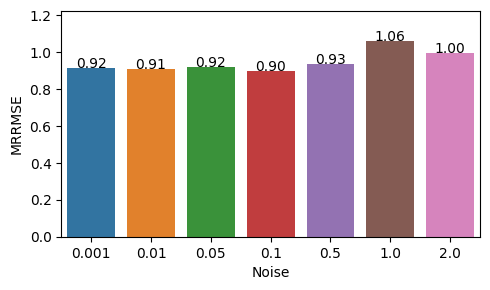

In [30]:
# create plot
plt.figure(figsize=(5, 3))
sns.barplot(data=pd.DataFrame({'noise': list(noise_errors.keys()), 'error': list(noise_errors.values())}), x='noise', y='error')
plt.ylabel('MRRMSE')
plt.xlabel('Noise')
plt.ylim(0, plt.ylim()[1] * 1.1)
for i, v in enumerate(noise_errors.values()):
    plt.text(i, v, "{:.2f}".format(v), ha="center")
plt.tight_layout()

In [31]:
# record final time
final_time = time.time()

# print time in minutes, seconds and hours
print('Total time: ' + str((final_time - initial_time) / 60) + ' minutes')

Total time: 8.902499147256215 minutes
